In [1]:
import numpy as np
import torch
from pathlib import Path
import os
from bnn_priors.models import RaoBDenseNet
import matplotlib.pyplot as plt
import math
from torch.distributions import Normal

from pyro.infer.mcmc import NUTS, HMC
from pyro.infer.mcmc.api import MCMC

import tqdm

In [2]:
data = np.load("../data/snelson.npz")

model = RaoBDenseNet(1, 1, 100, output_std=0.3)
if torch.cuda.is_available():
    model = model.cuda()

x_train = torch.from_numpy(data['x_train']).unsqueeze(1).to(model.lin1.weight)
y_train = torch.from_numpy(data['y_train']).unsqueeze(1).to(x_train)

x_test = torch.from_numpy(data['x_test']).unsqueeze(1).to(x_train)

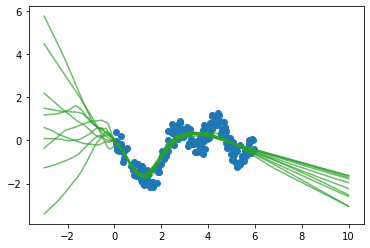

In [3]:
for _ in range(10):
    model.sample_all_priors()
    with torch.no_grad():
        plt.plot(x_test.cpu(), model(x_test, x_train=x_train, y_train=y_train).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()

In [5]:
N_steps = 1000
warmup = 500

#model.requires_grad_(True)
#model.sample_all_priors()
#optim = torch.optim.SGD(model.parameters(), lr=0.01)
#potential_fn = model.get_potential(x_train, y_train)
#for i in range(20):
#    optim.zero_grad()
#    pot = potential_fn({})
#    if i%10 == 9:
#        print("i=", i, "potential=", pot.item())
#    pot.backward()
#    optim.step()


kernel = NUTS(potential_fn=model.get_potential(x_train, y_train), adapt_step_size=False,
              adapt_mass_matrix=True, step_size=3e-5, max_tree_depth=6)
mcmc = MCMC(kernel, num_samples=N_steps, warmup_steps=warmup, initial_params = model.params_with_prior_dict())
#cProfile.run('mcmc.run(x=x_train, y=y_train)')
mcmc.run(x=x_train, y=y_train)

samples = mcmc.get_samples()

Sample: 100%|██████████| 1500/1500 [09:39,  2.59it/s, step size=3.00e-05, acc. prob=0.999]


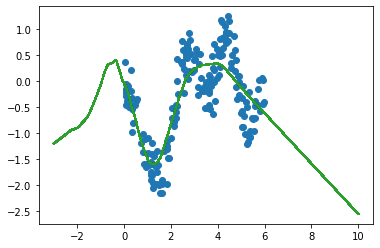

In [7]:
for i in range(N_steps):
    sample = dict((k, v[i]) for k, v in samples.items())
    with torch.no_grad(), model.using_params(sample):
        plt.plot(x_test.cpu(), model(x_test, x_train=x_train, y_train=y_train).loc.cpu(), color="C2", alpha=0.7)
plt.scatter(x_train.cpu(), y_train.cpu())
plt.show()